In [1]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 32.0 MB/s eta 0:00:00



✅ Dataset loaded and processed:
                 ID                         Title            Category Rating  \
0  a897fe39b1053632            A Light in the ...              Poetry  Three   
1  90fa61229261140a            Tipping the Velvet  Historical Fiction    One   
2  6957f44c3847a760                    Soumission             Fiction    One   
3  e00eb4fd7b871a48                 Sharp Objects             Mystery   Four   
4  4165285e1663650f  Sapiens: A Brief History ...             History   Five   

                                 content  
0              A Light in the ... Poetry  
1  Tipping the Velvet Historical Fiction  
2                     Soumission Fiction  
3                  Sharp Objects Mystery  
4   Sapiens: A Brief History ... History  


/tmp/ipython-input-429192717.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")


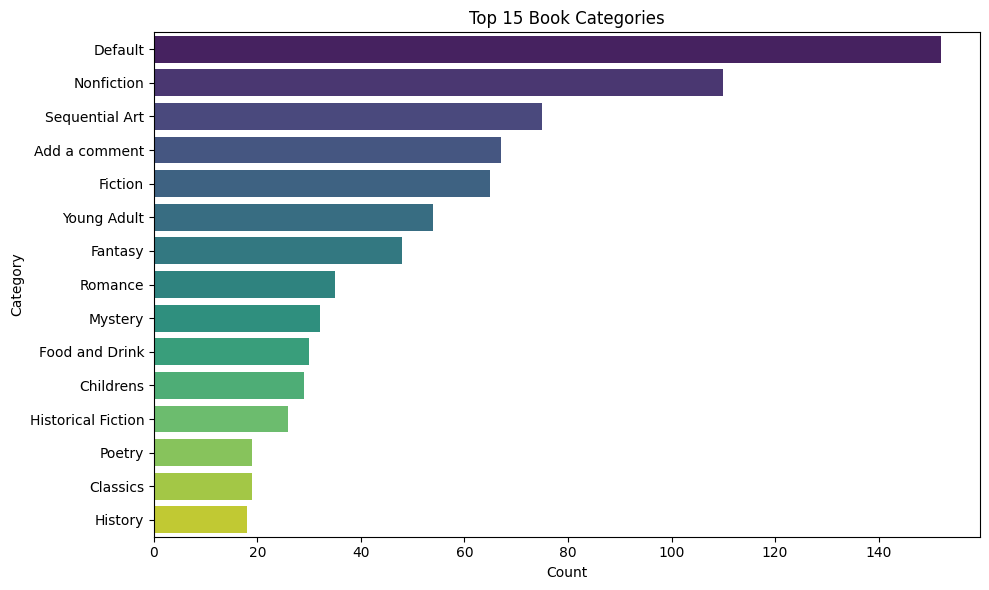

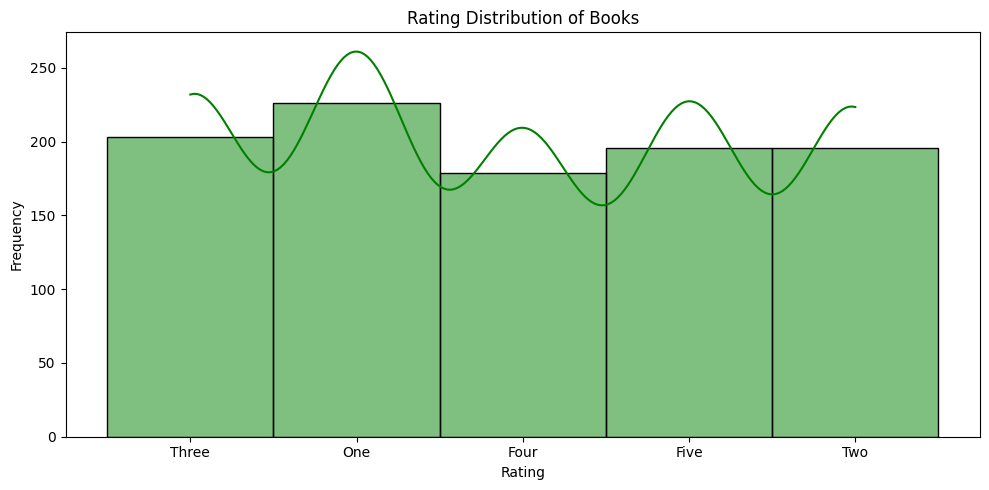

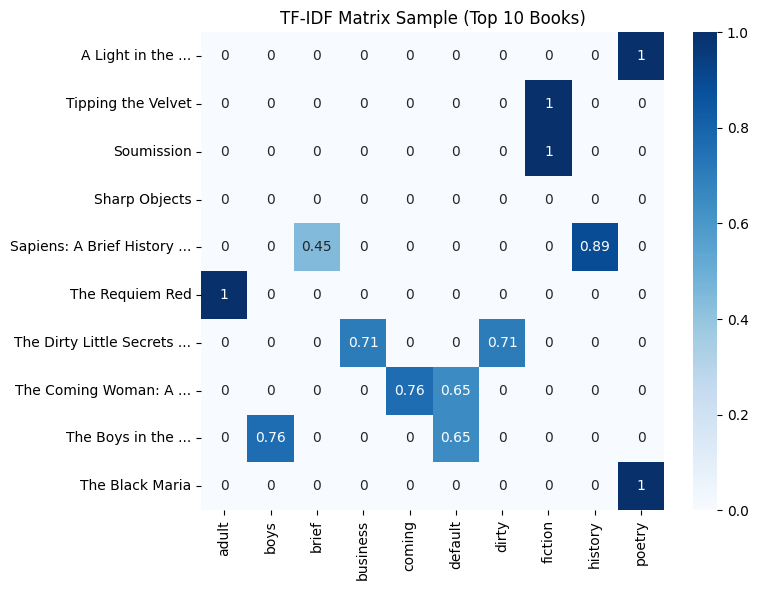

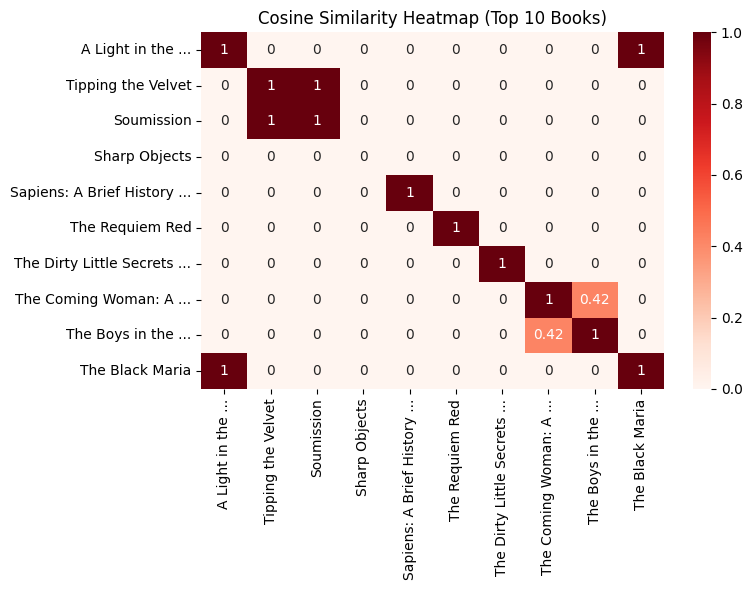


Top 5 recommendations for Title='The Four Agreemnts' only:
                     Title    Category Rating  similarity
926    The Name of the ...     Default  Three    0.874759
259       Take Me with You     Fiction  Three    0.864150
566  Me Before You (Me ...     Fiction    One    0.864150
476        I Will Find You  Nonfiction    One    0.851542
446            Why Not Me?  Nonfiction    One    0.851542

Top 5 recommendations for Genre='Fantasy' only:
                        Title Category Rating  similarity
927      The Mirror & the ...  Fantasy    One    0.506151
661   Paper and Fire (The ...  Fantasy   Five    0.506151
722        The Rose & the ...  Fantasy   Four    0.484536
877                       Ash  Fantasy   Four    0.484536
675  Harry Potter and the ...  Fantasy    One    0.428286

Top 5 recommendations for Title='The Four Agreemnts' + Genre='Fantasy':
                        Title Category Rating  similarity
927      The Mirror & the ...  Fantasy    One    0.606535
661   

In [2]:


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from rapidfuzz import process  # fuzzy matching

# 1️⃣ Load dataset

df = pd.read_csv("/content/books.csv")
df = df[['ID','Title','Category','Rating']].dropna()
df['content'] = df['Title'].astype(str) + " " + df['Category'].astype(str)

print("\n✅ Dataset loaded and processed:")
print(df.head())

-
# 2️⃣ Top 15 Book Categories

plt.figure(figsize=(10,6))
top_cats = df['Category'].value_counts().nlargest(15)
sns.barplot(x=top_cats.values, y=top_cats.index, palette="viridis")
plt.title("Top 15 Book Categories")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


# 3️⃣ Rating Distribution

plt.figure(figsize=(10,5))
sns.histplot(df['Rating'], bins=10, kde=True, color='green')
plt.title("Rating Distribution of Books")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# 4️⃣ TF-IDF Feature Matrix Sample (Top 10 books, top 10 words)

tfidf_sample = TfidfVectorizer(stop_words='english', max_features=10)
tfidf_matrix_sample = tfidf_sample.fit_transform(df['content'][:10])
plt.figure(figsize=(8,6))
sns.heatmap(tfidf_matrix_sample.todense(), annot=True, cmap='Blues', xticklabels=tfidf_sample.get_feature_names_out(), yticklabels=df['Title'][:10])
plt.title("TF-IDF Matrix Sample (Top 10 Books)")
plt.tight_layout()
plt.show()


# 5️⃣ Cosine Similarity Heatmap (Top 10 books)

cos_sim_sample = cosine_similarity(tfidf_matrix_sample)
plt.figure(figsize=(8,6))
sns.heatmap(cos_sim_sample, annot=True, cmap='Reds', xticklabels=df['Title'][:10], yticklabels=df['Title'][:10])
plt.title("Cosine Similarity Heatmap (Top 10 Books)")
plt.tight_layout()
plt.show()


# 6️⃣ Fuzzy Matching Function

def get_closest_title(input_title, titles_list):
    match = process.extractOne(input_title, titles_list)
    return match[0]


# 7️⃣ Recommendation Function (Weighted Title Boosting)

def recommend_books(title=None, genre=None, top_n=5, title_boost=3):
    if not title and not genre:
        return ["⚠ Please provide a title or a genre"]

    # Prepare query text
    query_text = ""
    if title:
        matched_title = get_closest_title(title, df['Title'].tolist())
        query_text = matched_title

    if genre:
        query_text += " " + genre

    # Boost title words in TF-IDF
    content_list = []
    for idx, row in df.iterrows():
        text = row['content']
        if title:
            for word in matched_title.split():
                text += (" " + word) * title_boost
        content_list.append(text)

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(content_list)
    query_vec = tfidf.transform([query_text])

    # Cosine similarity
    cosine_sim = cosine_similarity(query_vec, tfidf_matrix).flatten()
    df['similarity'] = cosine_sim

    # Sort and get top N recommendations
    recommendations = df.sort_values(by='similarity', ascending=False)

    # Exclude the input title itself
    if title:
        recommendations = recommendations[recommendations['Title'] != matched_title]

    # Filter by genre if provided
    if genre:
        recommendations = recommendations[recommendations['Category'].str.contains(genre, case=False)]

    top_recs = recommendations[['Title','Category','Rating','similarity']].head(top_n)

    # ----------------------------
    # Recommendation Strength Heatmap
    # ----------------------------
    #plt.figure(figsize=(8,4))
    #sns.heatmap(top_recs[['similarity']].T, annot=True, cmap='coolwarm', xticklabels=top_recs['Title'])
    #plt.title(f"Recommendation Strength Heatmap for '{title}'")
    #plt.yticks(rotation=0)
    #plt.xticks(rotation=45, ha='right')
    #plt.tight_layout()
    #plt.show()

    return top_recs

# ----------------------------
# 8️⃣ Example Queries
# ----------------------------
print("\nTop 5 recommendations for Title='The Four Agreemnts' only:")
print(recommend_books(title="The Four Agreemnts"))

print("\nTop 5 recommendations for Genre='Fantasy' only:")
print(recommend_books(genre="Fantasy"))

print("\nTop 5 recommendations for Title='The Four Agreemnts' + Genre='Fantasy':")
print(recommend_books(title="The Four Agreemnts", genre="Fantasy"))
